In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

In [4]:
# ============= Import required packaages ==============
import time

# Import all custom variables and modules
from custom_classes_defs_revised.preprocessing_w import *
from custom_classes_defs_revised.unet0 import *

#from custom_classes_defs.preprocessing import *
# from custom_classes_defs.unet0 import * 
# from custom_classes_defs.Unet_like import *  
# from custom_classes_defs.unet import *  
# from custom_classes_defs.fnet0 import *
#from custom_classes_defs.fnet_like import *
# from custom_classes_defs.fnet import *

RND_STATE = 247
BATCH_SIZE = 512
EPOCHS = 100
keras.utils.set_random_seed(RND_STATE)
from keras.utils import plot_model

INTERACTIVE_SESSION = True

# -------------------------------------------------------

2024-06-06 00:58:14.269997: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 00:58:15.973066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 00:58:15.973946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 00:58:16.216889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-06 00:58:16.639574: I tensorflow/core/platform/cpu_feature_guar

In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

if NUM_GPU:
    # print GPU info
    !nvidia-smi
    
if NUM_GPU>1:
    strategy = tf.distribute.MirroredStrategy()
    # strategy = tf.distribute.MultiWorkerMirroredStrategy()
    BATCH_SIZE = strategy.num_replicas_in_sync * BATCH_SIZE

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1


/usr/local/bin/bash: /opt/miniconda3-py311/lib/libtinfo.so.6: no version information available (required by /usr/local/bin/bash)


Thu Jun  6 00:59:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:3B:00.0 Off |                    0 |
| N/A   43C    P0              36W / 250W |   1637MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

### Data preparation and model configurations

In [6]:
print("{}\n\t{}\n{}".format('='*55,'Data preparation and model configurations', '-'*55))
# Images and annations for Thebe seismic data
start = time.time()

seis_path = '../data_wisting/'
label_path = '../data_wisting/'
wisting = Thebe(seis_path,label_path)

# Create datasets for respective data samples and labels
x_test, y_test = wisting.data_generator(sub_group='test',as_numpy=True)
        
print("Size of test data: {}".format(wisting.test_size)) 

print('...elapsed time: ___{:5.2f} minutes___'.format((time.time()-start) / 60))

	Data preparation and model configurations
-------------------------------------------------------


Size of test data: 5598
...elapsed time: ___ 0.01 minutes___


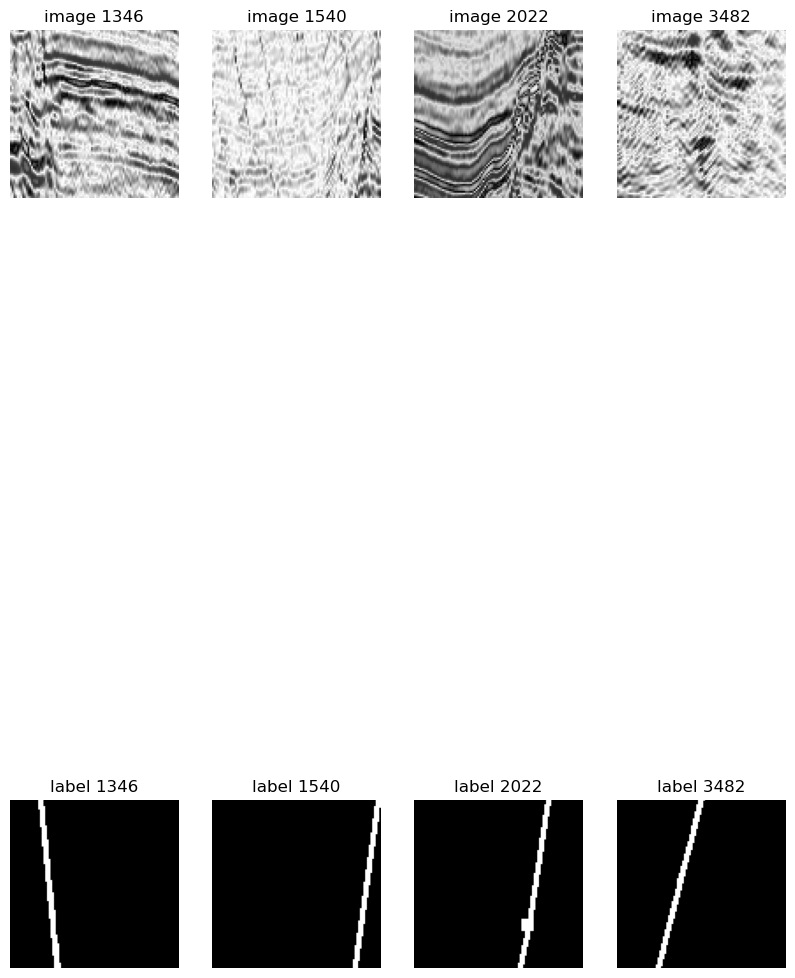

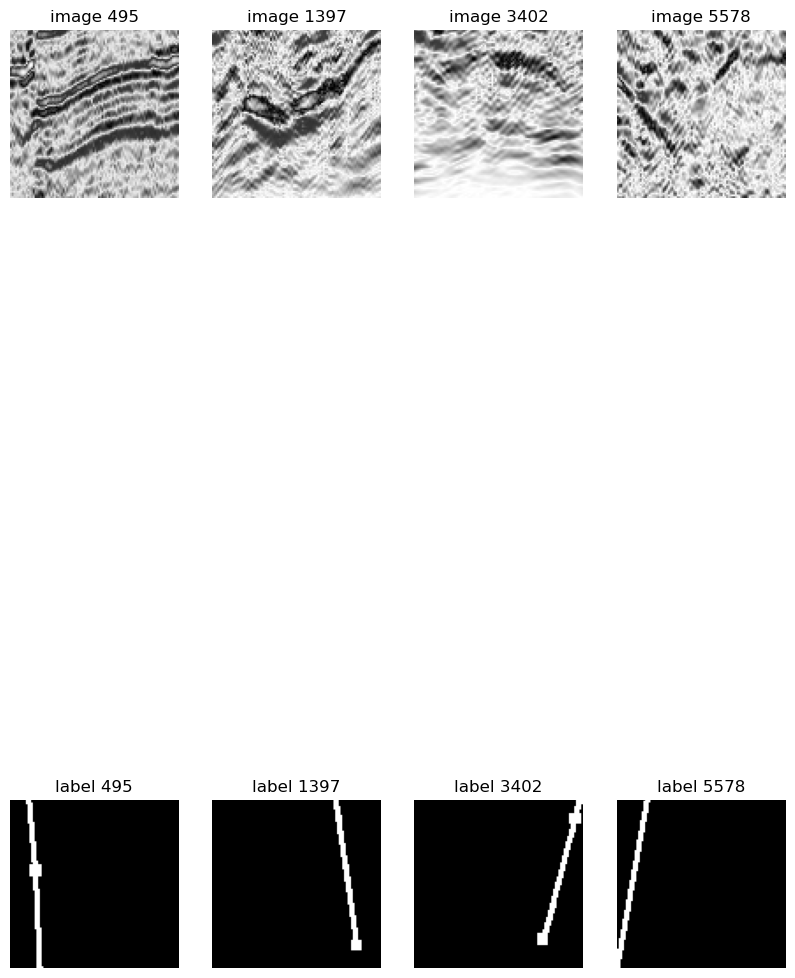

In [7]:
if INTERACTIVE_SESSION:
    wisting.display_sample_images(x_test, y_test, num_images=4)
    wisting.display_sample_images(x_test, y_test, num_images=4)


In [8]:
# Model configurations
conf = model_config(
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    scaling=1,
    save_path='./Thebe/new/unet0',
    img_shape=wisting.img_size,
    target_size=wisting.img_size,
    threshold=wisting.threshold,
    pos_label=wisting.pos_label,
    train_size=wisting.train_size,
    test_size=wisting.test_size,
    multiple_gpu_device=(NUM_GPU>1),
    validation_size=wisting.validation_size
)

assert not(conf.new_training_session)

conf.info()

             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: False
           pos_label: 1
           save_path: ./Thebe/new/unet0
             scaling: 1
         target_size: (96, 96)
           test_size: 5598
           threshold: 0.5
          train_size: None
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle: True
                       verbose: 0
   training_duration: None
     validation_size: None


2024-06-06 00:59:27.339831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38374 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0


### Build  model 

In [9]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    print(f"Number of devices: {strategy.num_replicas_in_sync}")

m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
#m_obj = FNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
model = m_obj.build_model()
# model.compile(**conf.compile_args)


# model.summary()
# keras.utils.plot_model(model, 'm_obj.png',show_shapes=True)
# plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 2,145,953
Total trainable wieghts: 2,143,137
Total non-trainable wieghts: 2,816


### Train  model



	Train unet model
-------------------------------------------------------


model train history 'model+_history.pickle'loaded!
             NUM_GPU: 1
        augmentation: False
        channels_dim: (1, 1)
        compile_args:
                     optimizer: adam
                          loss: binary_crossentropy
                       metrics: accuracy
                              : f1_score(name=f1_score,dtype=float32)
           img_shape: (96, 96)
              labels: ListWrapper([0, 1])
     mixed_precision: None
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
 multiple_gpu_device: False
new_training_session: True
           pos_label: 1
           save_path: ./Thebe/new/unet0
             scaling: 1
         target_size: (96, 96)
           test_size: 224122
           threshold: 0.5
          train_size: 181029
       training_args:
                        epochs: 100
               

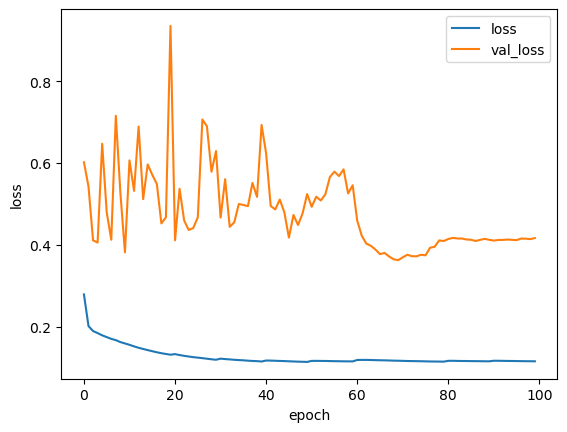

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=None, 
        plot_history=INTERACTIVE_SESSION
)


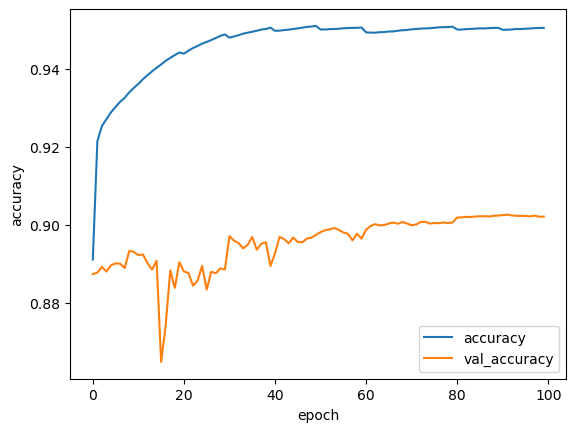

In [11]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['accuracy','val_accuracy'])

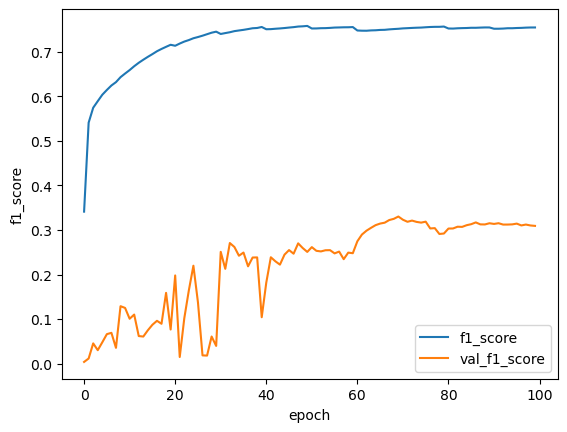

In [12]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, ['f1_score','val_f1_score'])

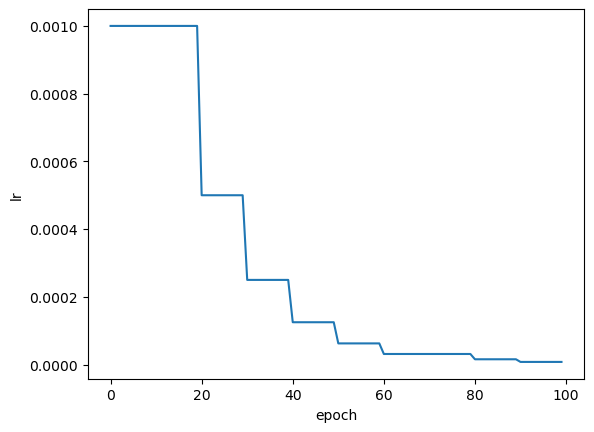

In [13]:
if INTERACTIVE_SESSION:
    show_convergence(train_history.history, 'lr')

### Evaluate and Vizualize

In [14]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))
start = time.time()
y_pred = model.predict(x_test, batch_size=BATCH_SIZE)

start = time.time() - start
print("evaluation elapsed time:___{:5.2f}___minutes" \
                .format(start/60))




	Evaluate unet model
-------------------------------------------------------


2024-06-06 01:00:00.728426: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


 1/11 [=>............................] - ETA: 2:49

 3/11 [=======>......................] - ETA: 0s  

 4/11 [=========>....................] - ETA: 0s

 5/11 [============>.................] - ETA: 0s

 6/11 [===============>..............] - ETA: 0s

 7/11 [==================>...........] - ETA: 0s

 8/11 [====================>.........] - ETA: 0s

 9/11 [=======================>......] - ETA: 0s

10/11 [==========================>...] - ETA: 0s

11/11 [==============================] - ETA: 0s

11/11 [==============================] - 22s 530ms/step


evaluation elapsed time:___ 0.39___minutes


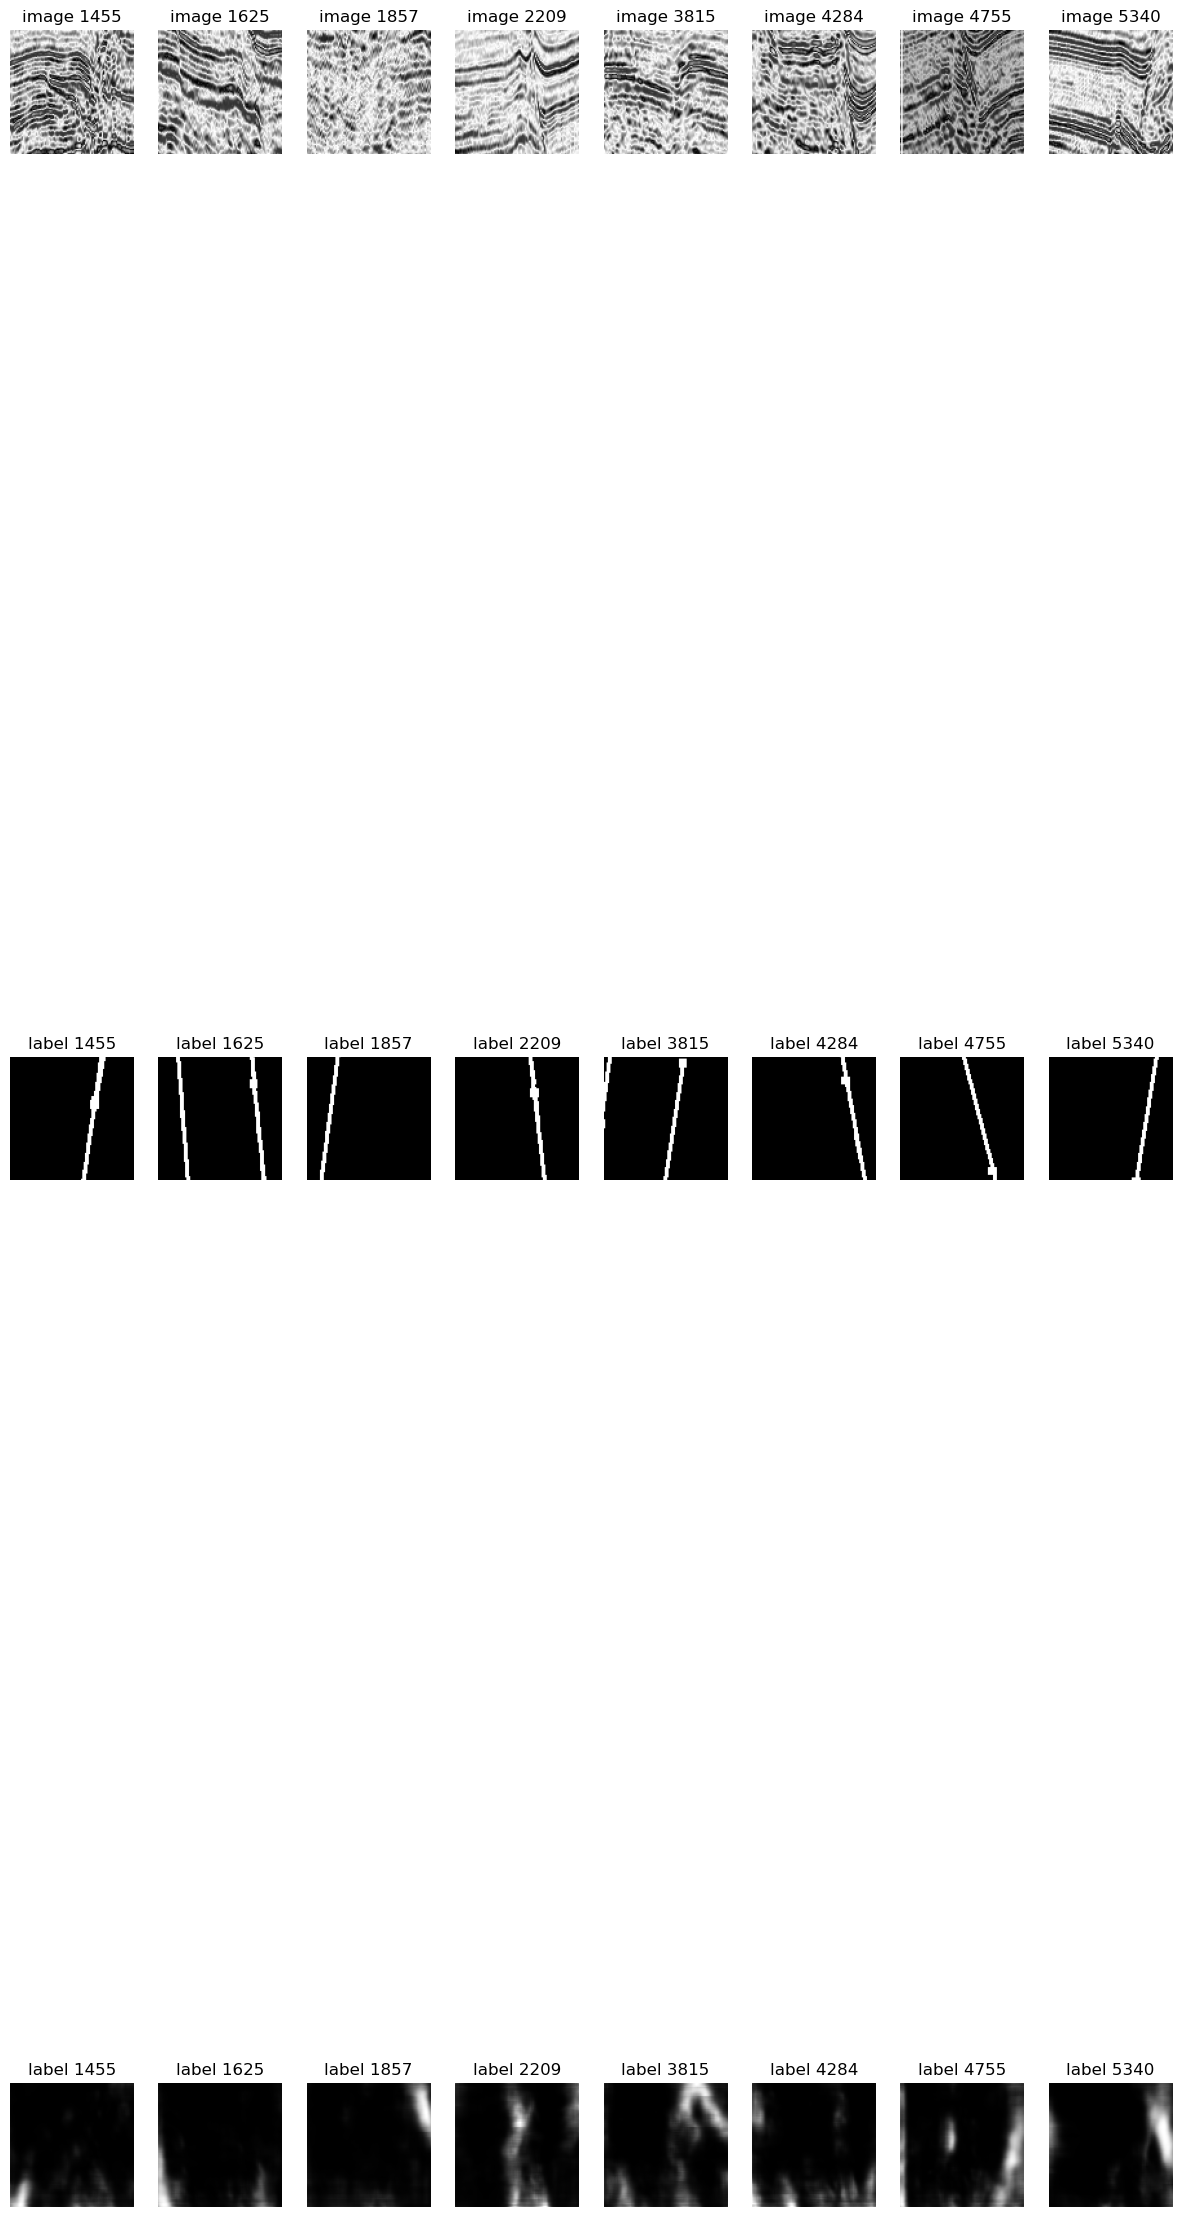

In [15]:

if INTERACTIVE_SESSION:
    wisting.display_sample_images(x_test, y_test, y_pred)
    

In [16]:

scores = conf.evaluate_sklearn(y_test, y_pred,report=True)
print(scores)

evaluation elapsed time:___ 3.28___minutes
                     0           1  accuracy    macro avg  weighted avg
precision         0.98        0.05      0.51         0.51          0.94
recall            0.51        0.69      0.51         0.60          0.51
f1-score          0.67        0.10      0.51         0.38          0.65
support    49595453.00  1995715.00      0.51  51591168.00   51591168.00
{'Avg-precision': 0.06, 'f1-score(ODS)': 0.1}
